## Obtaining the Best Chi-Square Cut

This iPython notebook will help you ascertain the best chi-square cut for a certain supernova's ATLAS light curve. After running a cell, the descriptions located above that cell will help you interpret the plots and make decisions about the supernova.

This notebook takes into account ATLAS's periodic replacement of the difference image reference templates, which may cause step discontinuities in flux. Two template changes have been recorded at MJDs 58417 and 58882. More information can be found here: https://fallingstar-data.com/forcedphot/faq/.

In order for this notebook to work correctly, the ATLAS light curve must already be downloaded and saved. It must also only include measurements for a single filter.

### 1: Setup: load the ATLAS light curve, account for template changes, etc.

In [12]:
# import modules, set preliminary variables, etc.

import sys
import numpy as np

# storing, accessing, and manipulating the light curve
import pandas as pd
from pdastro import pdastrostatsclass, AandB, AnotB, AorB, not_AandB

# getting discovery date from TNS
import requests, json
from collections import OrderedDict
from astropy.time import Time

# plotting
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pylab as matlib
import warnings
warnings.simplefilter('error', RuntimeWarning)
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [12, 7]
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'Times'
plt.rcParams['font.size'] = 13

# ATLAS template changes
global tchange1
global tchange2
tchange1 = 58417
tchange2 = 58882

# dictionary for storing important information about the light curve
global lc_info
lc_info = {}

In [13]:
# Enter the target SN name:
tnsname = '2019vxm'

# Enter the SN light curve file name:
filename = '/Users/sofiarest/Google Drive/My Drive/College/STScI Research Paper/atlaslc_chisquare/brightsne/2019vxm/2019vxm_i000.o.lc.txt'

# Enter the filter for this light curve (must be 'o' or 'c'):
filter = 'o'

# Optionally, enter the SN's discovery date (if None is entered, it will be 
# fetched automatically from TNS):
discdate = None

In [14]:
# get discovery date if needed, load in light curve, account for template changes, 
# and add uJy/duJy column

def get_tns_data(tnsname):
	try:
		get_obj = [("objname",tnsname), ("objid",""), ("photometry","1"), ("spectra","1")]
		get_url = 'https://www.wis-tns.org/api/get/object'
		json_file = OrderedDict(get_obj)
		get_data = {'api_key':'2eca323a16b17d78fbc99cd6f1f801699a81a91c','data':json.dumps(json_file)}
		response = requests.post(get_url, data=get_data, headers={'User-Agent':'tns_marker{"tns_id":104739,"type": "bot", "name":"Name and Redshift Retriever"}'})
		json_data = json.loads(response.text,object_pairs_hook=OrderedDict)
		return json_data
	except Exception as e:
		return 'Error: \n'+str(e)

def get_discdate(tnsname):
	json_data = get_tns_data(tnsname)
	discoverydate = json_data['data']['reply']['discoverydate']
	date = list(discoverydate.partition(' '))[0]
	time = list(discoverydate.partition(' '))[2]
	disc_date_format = date+'T'+time
	dateobjects = Time(disc_date_format, format='isot', scale='utc')
	disc_date = dateobjects.mjd
	return disc_date

def load_lc(filename):
	lc_info['lc'] = pdastrostatsclass()
	try:
		print('Loading SN %s light curve at %s...' % (lc_info['tnsname'], filename))
		lc_info['lc'].load_spacesep(filename,delim_whitespace=True)
	except Exception as e:
		print('Could not load light curve for SN %s at %s: %s' % (lc_info['tnsname'], filename, str(e)))
		sys.exit()
	
	# get median baseline flux and subtract from all measurements to account for template shifts
	baseline = np.where(lc_info['lc'].t['MJD'] < lc_info['discdate'])[0]
	median_bflux = np.median(lc_info['lc'].t.loc[baseline,'uJy'])
	print('Subtracting median flux %0.1f uJy from light curve flux to account for template shifts...' % median_bflux)
	lc_info['lc'].t['uJy'] -= median_bflux

	# add flux/dflux column
	print('Adding uJy/duJy column to light curve...')
	lc_info['lc'].t['uJy/duJy'] = lc_info['lc'].t['uJy']/lc_info['lc'].t['duJy']
	lc_info['lc'].t = lc_info['lc'].t.replace([np.inf, -np.inf], np.nan)


lc_info['tnsname'] = tnsname

if filter != 'o' and filter != 'c': 
	print('Filter must be "o" or "c"!')
	sys.exit()
lc_info['filter'] = filter

if discdate is None:
	print('Obtaining SN %s discovery date from TNS...' % lc_info['tnsname'])
	discdate = get_discdate(lc_info['tnsname'])
	print('Discovery date: ',discdate)
lc_info['discdate'] = discdate

load_lc(filename)

lc_info['baseline_i'] = np.where(lc_info['lc'].t['MJD'] < lc_info['discdate'])[0]
lc_info['afterdiscdate_i'] = np.where(lc_info['lc'].t['MJD'] > lc_info['discdate'])[0]

Obtaining SN 2019vxm discovery date from TNS...
Discovery date:  58818.04
Loading SN 2019vxm light curve at /Users/sofiarest/Google Drive/My Drive/College/STScI Research Paper/atlaslc_chisquare/brightsne/2019vxm/2019vxm_i000.o.lc.txt...
Subtracting median flux 30.0 uJy from light curve flux to account for template shifts...
Adding uJy/duJy column to light curve...


### 2: Plot the ATLAS light curve

In [15]:
# Enter the scaling parameter for the plot's upper y limit 
# (ylim_upper = scale * 95th percentile flux):
scale = 2

# Optionally, manually enter the plot's x and y limits to override automatic scaling:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

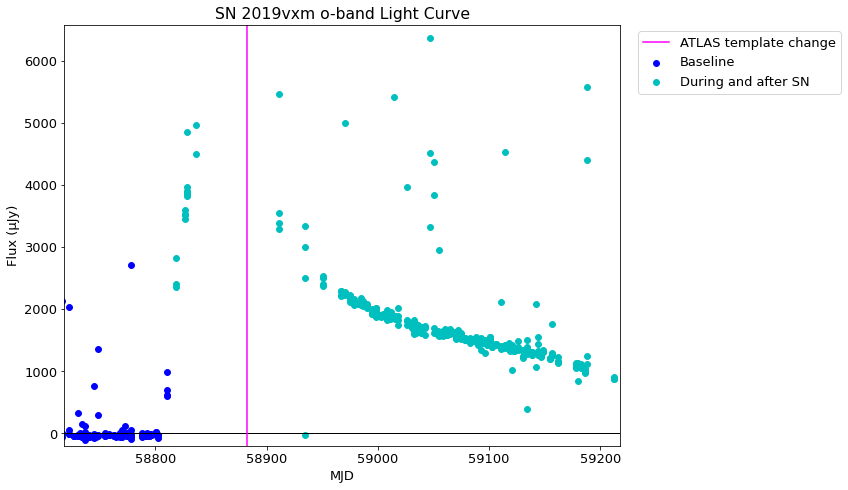

In [16]:
# plot the light curve

def get_xth_percentile_flux(percentile, indices):
    if len(indices)==0: 
        return None
    else:
        return np.percentile(lc_info['lc'].t.loc[indices, 'uJy'], percentile)

def plot_lc(xlim_lower=None, xlim_upper=None, ylim_lower=None, ylim_upper=None):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.axhline(linewidth=1,color='k')
    ax.set_ylabel('Flux (µJy)')
    ax.set_xlabel('MJD')
    ax.set_title('SN %s %s-band Light Curve' % (lc_info['tnsname'], lc_info['filter']))
    ax.axvline(x=tchange1,color='magenta', label='ATLAS template change')
    ax.axvline(x=tchange2,color='magenta')

    # set x and y limits
    if xlim_lower is None: xlim_lower = lc_info['discdate']-100
    if xlim_upper is None: xlim_upper = lc_info['discdate']+400
    ax.set_xlim(xlim_lower, xlim_upper)
    if ylim_lower is None: ylim_lower = -200
    if ylim_upper is None: ylim_upper = scale*get_xth_percentile_flux(95, lc_info['afterdiscdate_i'])
    ax.set_ylim(ylim_lower,ylim_upper)

    ax.scatter(lc_info['lc'].t.loc[lc_info['baseline_i'],'MJD'], lc_info['lc'].t.loc[lc_info['baseline_i'],'uJy'], 
               s=35,color='b',marker='o',label='Baseline')

    ax.scatter(lc_info['lc'].t.loc[lc_info['afterdiscdate_i'],'MJD'], lc_info['lc'].t.loc[lc_info['afterdiscdate_i'],'uJy'],
               s=35,color='c',marker='o',label='During and after SN')
    
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

    fig.tight_layout()

plot_lc(xlim_lower=xlim_lower, xlim_upper=xlim_upper, ylim_lower=ylim_lower, ylim_upper=ylim_upper)

### 3: Plot the flux/dflux and chi-square distributions

[INSERT DESCRIPTION HERE]

In [17]:
# Optionally, manually enter the histograms' x limits here:
fdf_xlim_lower = None
fdf_xlim_upper = 300
x2_xlim_lower = None
x2_xlim_upper = 2000

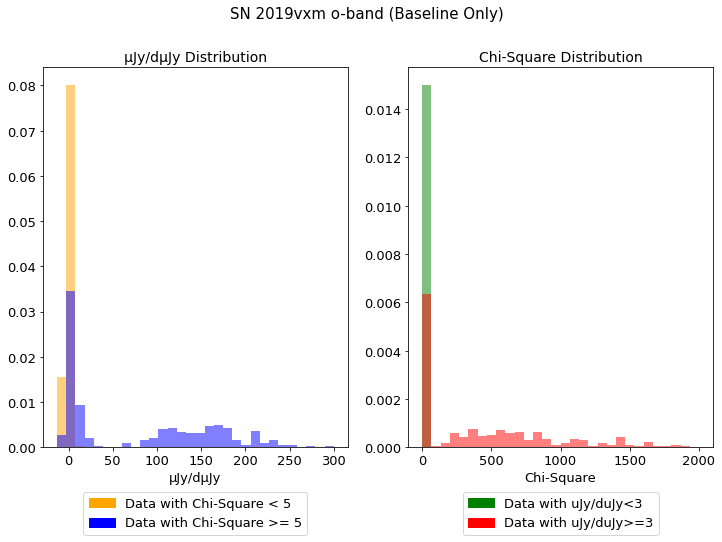

In [18]:
# plot flux/dflux and chi-square distribution histograms

def plot_hists(fdf_xlim_lower=None, fdf_xlim_upper=None, x2_xlim_lower=None, x2_xlim_upper=None):
    good_stn_b_i = AandB(lc_info['baseline_i'], np.where(lc_info['lc'].t['uJy/duJy'] < 3.0)[0])
    bad_stn_b_i = AandB(lc_info['baseline_i'], np.where(lc_info['lc'].t['uJy/duJy'] >= 3.0)[0])
    good_x2_b_i = AandB(lc_info['baseline_i'], np.where(lc_info['lc'].t['chi/N'] < 5.0)[0])
    bad_x2_b_i = AandB(lc_info['baseline_i'], np.where(lc_info['lc'].t['chi/N'] >= 5.0)[0])

    fig, axes = plt.subplots(nrows=1, ncols=2)
    stn, x2 = axes.flatten()
    plt.suptitle('SN %s %s-band (Baseline Only)' % (lc_info['tnsname'], lc_info['filter']), fontsize=15, y=1)

    stn.set_title('µJy/dµJy Distribution', fontsize=14)
    stn.set_xlabel('µJy/dµJy')
    orange = mpatches.Patch(color='orange', label='Data with Chi-Square < 5')
    blue = mpatches.Patch(color='blue', label='Data with Chi-Square >= 5')
    stn.legend(handles=[orange, blue], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
    if len(lc_info['baseline_i'])>0: 
        if fdf_xlim_lower is None: 
            fdf_xlim_lower = min(lc_info['lc'].t.loc[lc_info['baseline_i'], 'uJy/duJy'])
        if fdf_xlim_upper is None: 
            fdf_xlim_upper = max(lc_info['lc'].t.loc[lc_info['baseline_i'], 'uJy/duJy'])
        stn.hist(lc_info['lc'].t.loc[good_x2_b_i, 'uJy/duJy'], bins=30, color='orange', alpha=0.5, range=(fdf_xlim_lower,fdf_xlim_upper), density=True)
        stn.hist(lc_info['lc'].t.loc[bad_x2_b_i, 'uJy/duJy'], bins=30, color='blue', alpha=0.5, range=(fdf_xlim_lower,fdf_xlim_upper), density=True)
    else:
        stn.hist(lc_info['lc'].t.loc[good_x2_b_i, 'uJy/duJy'], bins=30, color='orange', alpha=0.5, density=True)
        stn.hist(lc_info['lc'].t.loc[bad_x2_b_i, 'uJy/duJy'], bins=30, color='blue', alpha=0.5, density=True)

    x2.set_title('Chi-Square Distribution', fontsize=14)
    x2.set_xlabel('Chi-Square')
    red = mpatches.Patch(color='green', label='Data with uJy/duJy<3')
    green = mpatches.Patch(color='red', label='Data with uJy/duJy>=3')
    x2.legend(handles=[red, green], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
    if len(lc_info['baseline_i'])>0:
        if x2_xlim_lower is None: 
            x2_xlim_lower = min(lc_info['lc'].t.loc[lc_info['baseline_i'], 'chi/N'])
        if x2_xlim_upper is None: 
            x2_xlim_upper = max(lc_info['lc'].t.loc[lc_info['baseline_i'], 'chi/N'])
        x2.hist(lc_info['lc'].t.loc[good_stn_b_i, 'chi/N'], bins=30, color='green', alpha=0.5, range=(x2_xlim_lower,x2_xlim_upper), density=True)
        x2.hist(lc_info['lc'].t.loc[bad_stn_b_i, 'chi/N'], bins=30, color='red', alpha=0.5, range=(x2_xlim_lower,x2_xlim_upper), density=True)
    else:
        x2.hist(lc_info['lc'].t.loc[good_stn_b_i, 'chi/N'], bins=30, color='green', alpha=0.5, density=True)
        x2.hist(lc_info['lc'].t.loc[bad_stn_b_i, 'chi/N'], bins=30, color='red', alpha=0.5, density=True)

plot_hists(fdf_xlim_lower=fdf_xlim_lower, fdf_xlim_upper=fdf_xlim_upper, x2_xlim_lower=x2_xlim_lower, x2_xlim_upper=x2_xlim_upper)

### 4: Calculate best chi-square cut based on contamination and loss

[INSERT DESCRIPTION]

In [19]:
# Enter the contamination limit (contamination=Nbad,kept/Nkept must be <= contam_lim%):
contam_lim = 10.0

# Enter the loss limit (loss=Ngood,cut/Ngood must be >= loss_lim%):
loss_lim = 10.0

# Enter the limit to prioritize (must be 'loss_lim' or 'contam_lim', 
# based on which is more important):
lim_to_prioritize = 'loss_lim'

# Enter the parameters for the chi-square cut (minimum cut, maximum cut, and step):
cut_start = 3 # this is inclusive
cut_stop = 50 # this is inclusive
cut_step = 1

# Enter the uJy/duJy cut that will determine a "good" measurement from a "bad" measurement:
stn_cut = 3

abs(uJy/duJy) cut at 3.00 
x2 cut from 3.00 to 50.00 inclusive, with step size 1
Static chi square cut at 50: 16.31% cut for baseline

Contamination cut according to given contam_limit, with 14.13% contamination and 25.59% loss: 3
Loss cut according to given loss_limit, with 15.58% contamination and 8.16% loss: 6
Prioritizing loss_lim and setting to 6... 

Final suggested chi-square cut is 6, with 15.58% contamination and 8.16% loss.


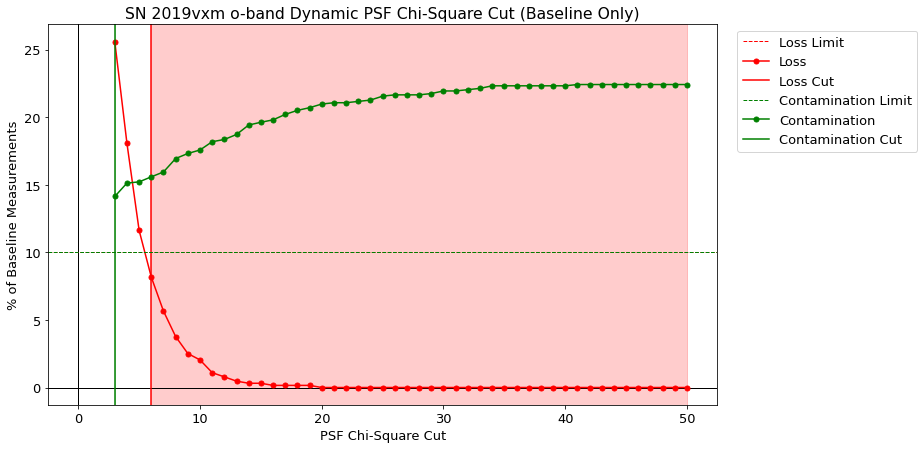

In [28]:
# IN PROGESS: calculate the suggested best chi-square cut using contamination and loss

def plot_lim_cuts(lim_cuts, contam_lim_cut, loss_lim_cut):
    plt.figure()
    plt.title('SN %s %s-band Dynamic PSF Chi-Square Cut (Baseline Only)' % (lc_info['tnsname'],lc_info['filter']))

    plt.axhline(linewidth=1,color='k')
    plt.axvline(linewidth=1,color='k')
    plt.xlabel('PSF Chi-Square Cut')
    plt.ylabel('% of Baseline Measurements')

    plt.axhline(loss_lim,linewidth=1,color='r',linestyle='--',label='Loss Limit')
    plt.plot(lim_cuts.t['PSF Chi-Square Cut'], lim_cuts.t['Loss'],ms=5,color='r',marker='o',label='Loss')
    plt.axvline(x=loss_lim_cut,color='r',label='Loss Cut')
    plt.axvspan(loss_lim_cut, cut_stop, alpha=0.2, color='r')

    plt.axhline(contam_lim,linewidth=1,color='g',linestyle='--',label='Contamination Limit')
    plt.plot(lim_cuts.t['PSF Chi-Square Cut'], lim_cuts.t['Contamination'],ms=5,color='g',marker='o',label='Contamination')
    plt.axvline(x=contam_lim_cut,color='g',label='Contamination Cut')
    plt.axvspan(cut_start, contam_lim_cut, alpha=0.2, color='g')
    
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')


def choose_btwn_lim_cuts(contam_lim_cut, loss_lim_cut, contam_case, loss_case):
    # case 1 and 1: final_cut = 5
    # case 1 and 2: take limit of case 2
    # case 1 and 3: take limit of case 3
    # case 2 and 2: print lims don't work
    # case 2 and 3: choose_btwn_lim_cuts
    # case 3 and 3: choose_btwn_lim_cuts

    case1 = loss_case == 'below lim' or contam_case == 'below lim'
    case2 = loss_case == 'above lim' or contam_case == 'above lim'
    case3 = loss_case == 'crosses lim' or contam_case == 'crosses lim'

    final_cut = None
    if case1 and not case2 and not case3: # 1 and 1
        print('Valid chi-square cut range from %d to %d! Setting to 3...' % (loss_lim_cut, contam_lim_cut))
        final_cut = 3
    elif case1: # 1
        if case2: # and 2
            if loss_case == 'above lim':
                print('WARNING: contam_lim_cut <= %d falls below limit %0.2f%%, but loss_lim_cut >= %d falls above limit %0.2f%%! Setting to %d...' % (contam_lim_cut, contam_lim, loss_lim_cut, loss_lim, loss_lim_cut))
                final_cut = loss_lim_cut
            else:
                print('WARNING: loss_lim_cut <= %d falls below limit %0.2f%%, but contam_lim_cut >= %d falls above limit %0.2f%%! Setting to %d...' % (loss_lim_cut, loss_lim, contam_lim_cut, contam_lim, contam_lim_cut))
                final_cut = contam_lim_cut
        else: # and 3
            if loss_case == 'crosses lim':
                print('Contam_lim_cut <= %d falls below limit %0.2f%% and loss_lim_cut >= %d crosses limit %0.2f%%, setting to %d...' % (contam_lim_cut, contam_lim, loss_lim_cut, loss_lim, loss_lim_cut))
                final_cut = loss_lim_cut
            else:
                print('Loss_lim_cut <= %d falls below limit %0.2f%% and contam_lim_cut >= %d crosses limit %0.2f%%, setting to %d...' % (loss_lim_cut, loss_lim, contam_lim_cut, contam_lim, contam_lim_cut))
                final_cut = contam_lim_cut
    elif case2 and not case3: # 2 and 2
        print('ERROR: chi-square loss_lim_cut >= %d and contam_lim_cut <= %d both fall above limits %0.2f%% and %0.2f%%! Try setting less strict limits. Setting final cut to nan.' % (loss_lim_cut, contam_lim_cut, loss_lim, contam_lim))
        final_cut = np.nan
    else: # 2 and 3 or 3 and 3
        if loss_lim_cut > contam_lim_cut:
            print('WARNING: chi-square loss_lim_cut >= %d and contam_lim_cut <= %d do not overlap! ' % (loss_lim_cut, contam_lim_cut))
            if lim_to_prioritize == 'contam_lim':
                print('Prioritizing %s and setting to %d...' % (lim_to_prioritize, contam_lim_cut))
                final_cut = contam_lim_cut
            else:
                print('Prioritizing %s and setting to %d... ' % (lim_to_prioritize, loss_lim_cut))
                final_cut = loss_lim_cut
        else:
            print('Valid chi-square cut range from %d to %d! ' % (loss_lim_cut, contam_lim_cut))
            if lim_to_prioritize == 'contam_lim':
                print('Prioritizing %s and setting to %d... ' % (lim_to_prioritize, loss_lim_cut))
                final_cut = loss_lim_cut
            else:
                print('Prioritizing %s and setting to %d... ' % (lim_to_prioritize, contam_lim_cut))
                final_cut = contam_lim_cut
    return final_cut

def get_lim_cuts(lim_cuts): 
    contam_lim_cut = None
    loss_lim_cut = None
    contam_case = None
    loss_case = None

    sortby_loss = lim_cuts.t.iloc[(lim_cuts.t['Loss']).argsort()].reset_index()
    min_loss = sortby_loss.loc[0,'Loss']
    max_loss = sortby_loss.loc[len(sortby_loss)-1,'Loss']
    # if all loss below lim, loss_lim_cut is min cut
    if min_loss < loss_lim and max_loss < loss_lim:
        loss_case = 'below lim'
        loss_lim_cut = lim_cuts.t.loc[0,'PSF Chi-Square Cut']
    else:
        # else if all loss above lim, loss_lim_cut is min cut with min% loss
        if min_loss > loss_lim and max_loss > loss_lim:
            loss_case = 'above lim'
            a = np.where(lim_cuts.t['Loss'] == min_loss)[0]
        # else if loss crosses lim at some point, loss_lim_cut is min cut with max% loss <= loss_lim
        else:
            loss_case = 'crosses lim'
            valid_cuts = sortby_loss[sortby_loss['Loss'] <= loss_lim]
            a = np.where(lim_cuts.t['Loss'] == valid_cuts.loc[len(valid_cuts)-1,'Loss'])[0]
        # sort those indices by cuts
        b = lim_cuts.t.iloc[a]
        c = b.iloc[(b['PSF Chi-Square Cut']).argsort()].reset_index()
        loss_lim_cut = c.loc[0,'PSF Chi-Square Cut']

    sortby_contam = lim_cuts.t.iloc[(lim_cuts.t['Contamination']).argsort()].reset_index()
    min_contam = sortby_contam.loc[0,'Contamination']
    max_contam = sortby_contam.loc[len(sortby_contam)-1,'Contamination']
    # if all contam below lim, contam_lim_cut is max cut
    if min_contam < contam_lim and max_contam < contam_lim:
        contam_case = 'below lim'
        contam_lim_cut = lim_cuts.t.loc[len(lim_cuts.t)-1,'PSF Chi-Square Cut']
    else:
        # else if all contam above lim, contam_lim_cut is max cut with min% contam
        if min_contam > contam_lim and max_contam > contam_lim:
            contam_case = 'above lim'
            a = np.where(lim_cuts.t['Contamination'] == min_contam)[0]
        # else if contam crosses lim at some point, contam_lim_cut is max cut with max% contam <= contam_lim
        else:
            contam_case = 'crosses lim'
            valid_cuts = sortby_contam[sortby_contam['Contamination'] <= contam_lim]
            a = np.where(lim_cuts.t['Contamination'] == valid_cuts.loc[len(valid_cuts)-1,'Contamination'])[0]
        # sort those indices by cuts
        b = lim_cuts.t.iloc[a]
        c = b.iloc[(b['PSF Chi-Square Cut']).argsort()].reset_index()
        contam_lim_cut = c.loc[len(c)-1,'PSF Chi-Square Cut']

    return contam_lim_cut, loss_lim_cut, contam_case, loss_case

def get_lim_cuts_table(stn_cut, cut_start, cut_stop, cut_step, indices=None):
    print('abs(uJy/duJy) cut at %0.2f \nx2 cut from %0.2f to %0.2f inclusive, with step size %d' % (stn_cut,cut_start,cut_stop,cut_step))

    if indices is None: 
        indices = lc_info['baseline_i']

    lim_cuts = pdastrostatsclass(columns=['PSF Chi-Square Cut', 'N', 'Ngood', 'Nbad', 'Nkept', 'Ncut', 'Ngood,kept', 'Ngood,cut', 'Nbad,kept', 'Nbad,cut',
                                          'Pgood,kept', 'Pgood,cut', 'Pbad,kept', 'Pbad,cut', 'Ngood,kept/Ngood', 'Loss', 'Contamination'])
    
    # static cut at x2 = 50
    x2cut_50 = np.where(lc_info['lc'].t['chi/N'] < 50)[0]
    print('Static chi square cut at 50: %0.2f%% cut for baseline' % (100*len(AnotB(indices,x2cut_50))/len(indices)))

    # good baseline measurement indices
    b_stncut_i = AandB(indices, np.where(abs(lc_info['lc'].t['uJy/duJy']) < stn_cut)[0])
    # for different x2 cuts decreasing from 50
    for cut in range(cut_start,cut_stop+1,cut_step):
        # kept baseline measurement indices
        b_x2cut_i = AandB(indices, np.where(lc_info['lc'].t['chi/N'] < cut)[0])

        df = pd.DataFrame([[cut, len(indices), # N
                            len(b_stncut_i), # Ngood
                            len(AnotB(indices,b_stncut_i)), # Nbad
                            len(b_x2cut_i), # Nkept
                            len(AnotB(indices,b_x2cut_i)), # Ncut
                            len(AandB(b_stncut_i,b_x2cut_i)), # Ngood,kept
                            len(AnotB(b_stncut_i,b_x2cut_i)), # Ngood,cut
                            len(AnotB(b_x2cut_i,b_stncut_i)), # Nbad,kept
                            len(AandB(AnotB(indices,b_stncut_i),AnotB(indices,b_x2cut_i))), # Nbad,cut
                            100*len(AandB(b_stncut_i,b_x2cut_i))/len(indices), # Ngood,kept/Nbaseline
                            100*len(AnotB(b_stncut_i,b_x2cut_i))/len(indices), # Ngood,cut/Nbaseline 
                            100*len(AnotB(b_x2cut_i,b_stncut_i))/len(indices), # Nbad,kept/Nbaseline
                            100*len(AandB(AnotB(indices,b_stncut_i),AnotB(indices,b_x2cut_i)))/len(indices), # Nbad,cut/Nbaseline
                            100*len(AandB(b_stncut_i,b_x2cut_i))/len(b_stncut_i), # Ngood,kept/Ngood
                            100*len(AnotB(b_stncut_i,b_x2cut_i))/len(b_stncut_i), # Ngood,cut/Ngood = Loss
                            100*len(AnotB(b_x2cut_i,b_stncut_i))/len(b_x2cut_i)]], # Nbad,kept/Nkept = Contamination
                            columns=['PSF Chi-Square Cut', 'N', 'Ngood', 'Nbad', 'Nkept', 'Ncut', 'Ngood,kept', 'Ngood,cut', 'Nbad,kept', 'Nbad,cut',
                                     'Pgood,kept', 'Pgood,cut', 'Pbad,kept', 'Pbad,cut', 'Ngood,kept/Ngood', 'Loss', 'Contamination'])
        lim_cuts.t = pd.concat([lim_cuts.t,df],ignore_index=True)
    
    return lim_cuts

if lim_to_prioritize != 'loss_lim' and lim_to_prioritize != 'contam_lim':
    print("ERROR: lim_to_prioritize must be 'loss_lim' or 'contam_lim'!")
    sys.exit()

lim_cuts = get_lim_cuts_table(stn_cut, cut_start, cut_stop, cut_step)
#print(lim_cuts.t.to_string())

contam_lim_cut, loss_lim_cut, contam_case, loss_case = get_lim_cuts(lim_cuts)
print('\nContamination cut according to given contam_limit, with %0.2f%% contamination and %0.2f%% loss: %d'%(lim_cuts.t.loc[np.where(lim_cuts.t['PSF Chi-Square Cut']==contam_lim_cut)[0][0],'Contamination'], lim_cuts.t.loc[np.where(lim_cuts.t['PSF Chi-Square Cut']==contam_lim_cut)[0][0],'Loss'], contam_lim_cut))
print('Loss cut according to given loss_limit, with %0.2f%% contamination and %0.2f%% loss: %d'%(lim_cuts.t.loc[np.where(lim_cuts.t['PSF Chi-Square Cut']==loss_lim_cut)[0][0],'Contamination'], lim_cuts.t.loc[np.where(lim_cuts.t['PSF Chi-Square Cut']==loss_lim_cut)[0][0],'Loss'], loss_lim_cut))
lc_info['contam_case'] = contam_case
lc_info['loss_case'] = loss_case
lc_info['contam_lim_cut'] = contam_lim_cut
lc_info['loss_lim_cut'] = loss_lim_cut

final_cut = choose_btwn_lim_cuts(contam_lim_cut, loss_lim_cut, contam_case, loss_case)
lc_info['final_cut'] = final_cut
        
if np.isnan(final_cut):
    print('\nERROR: Final suggested chi-square cut could not be determined. We suggest rethinking your contamination and loss limits.')
    lc_info['Pcontamination'] = np.nan
    lc_info['Ploss'] = np.nan
else:
    lc_info['Pcontamination'] = lim_cuts.t.loc[np.where(lim_cuts.t['PSF Chi-Square Cut']==final_cut)[0][0],'Contamination']
    lc_info['Ploss'] = lim_cuts.t.loc[np.where(lim_cuts.t['PSF Chi-Square Cut']==final_cut)[0][0],'Loss']
    print('\nFinal suggested chi-square cut is %d, with %0.2f%% contamination and %0.2f%% loss.' % (final_cut, lc_info['Pcontamination'], lc_info['Ploss']))

plot_lim_cuts(lim_cuts, contam_lim_cut, loss_lim_cut)